In [5]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [19]:
CLASSES = ["adidas_symbol",
                  "adidas_text",
                  "aldi",
                  "apple",
                  "becks_symbol",
                  "becks_text",
                  "bmw",
                  "carlsberg_symbol",
                  "carlsberg_text",
                  "chimay_symbol",
                  "chimay_text",
                  "cocacola",
                  "corona_symbol",
                  "corona_text",
                  "dhl",
                  "erdinger_symbol",
                  "erdinger_text",
                  "esso_symbol",
                  "esso_text",
                  "fedex",
                  "ferrari",
                  "ford",
                  "fosters_symbol",
                  "fosters_text",
                  "google",
                  "guinness_symbol",
                  "guinness_text",
                  "heineken",
                  "milka",
                  "nvidia_symbol",
                  "nvidia_text",
                  "paulaner_symbol",
                  "paulaner_text",
                  "pepsi_symbol",
                  "pepsi_text",
                  "rittersport",
                  "shell",
                  "singha_symbol",
                  "singha_text",
                  "starbucks",
                  "stellaartois_symbol",
                  "stellaartois_text",
                  "texaco",
                  "tsingtao_symbol",
                  "tsingtao_text",
                  "ups",]

In [10]:
# load data
DATA_DIR = './FlickrLogos_47/'

x_train_dir = os.path.join(DATA_DIR, 'train/raw')
y_train_dir = os.path.join(DATA_DIR, 'train/masks')

x_test_dir = os.path.join(DATA_DIR, 'test/raw')
y_test_dir = os.path.join(DATA_DIR, 'test/masks')

In [11]:
# visulaize data func
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [12]:
# dataloader
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [13]:
class Dataset(BaseDataset):
    CLASSES = ["adidas_symbol",
                  "adidas_text",
                  "aldi",
                  "apple",
                  "becks_symbol",
                  "becks_text",
                  "bmw",
                  "carlsberg_symbol",
                  "carlsberg_text",
                  "chimay_symbol",
                  "chimay_text",
                  "cocacola",
                  "corona_symbol",
                  "corona_text",
                  "dhl",
                  "erdinger_symbol",
                  "erdinger_text",
                  "esso_symbol",
                  "esso_text",
                  "fedex",
                  "ferrari",
                  "ford",
                  "fosters_symbol",
                  "fosters_text",
                  "google",
                  "guinness_symbol",
                  "guinness_text",
                  "heineken",
                  "milka",
                  "nvidia_symbol",
                  "nvidia_text",
                  "paulaner_symbol",
                  "paulaner_text",
                  "pepsi_symbol",
                  "pepsi_text",
                  "rittersport",
                  "shell",
                  "singha_symbol",
                  "singha_text",
                  "starbucks",
                  "stellaartois_symbol",
                  "stellaartois_text",
                  "texaco",
                  "tsingtao_symbol",
                  "tsingtao_text",
                  "ups",]
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.maskids = os.listdir(masks_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.maskids if "mask00" in image_id]

        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        #with np.printoptions(threshold=np.inf):
        #    print(mask)
        #print(self.class_values)
        masks = [(mask == 255) for v in self.class_values]
        #print(masks)
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask

    def __len__(self):
        return len(self.ids)

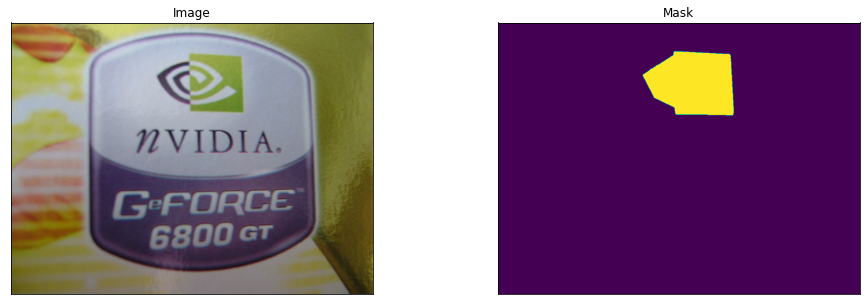

In [14]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['nvidia_symbol'])
#553
image, mask = dataset[553] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)

In [15]:
#Augmentations
import albumentations as albu

In [23]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

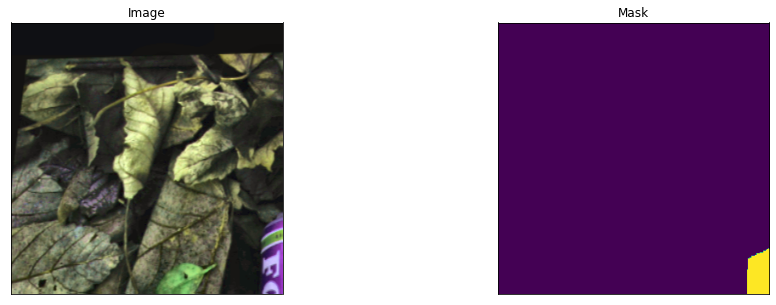

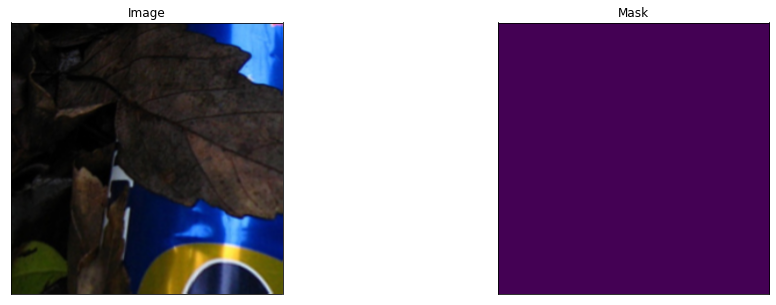

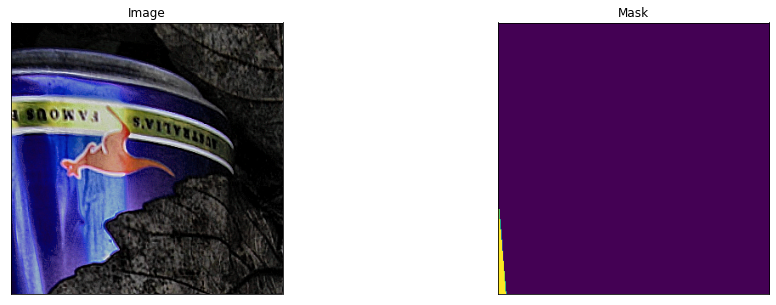

In [24]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=['nvidia_symbol'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

In [25]:
# create model
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [26]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = CLASSES
#ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [27]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir,
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
#valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [28]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [29]:
torch.cuda.is_available()

True

In [116]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

In [123]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < train_logs['iou_score']:
        max_score = train_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train: 100%|██████████| 105/105 [11:10<00:00,  6.39s/it, dice_loss - 0.7025, iou_score - 0.2135]
Model saved!

Epoch: 1
train: 100%|██████████| 105/105 [10:54<00:00,  6.23s/it, dice_loss - 0.5438, iou_score - 0.3473]
Model saved!

Epoch: 2
train: 100%|██████████| 105/105 [10:49<00:00,  6.18s/it, dice_loss - 0.5089, iou_score - 0.3759]
Model saved!

Epoch: 3
train: 100%|██████████| 105/105 [10:50<00:00,  6.20s/it, dice_loss - 0.416, iou_score - 0.4608] 
Model saved!

Epoch: 4
train: 100%|██████████| 105/105 [10:43<00:00,  6.13s/it, dice_loss - 0.4467, iou_score - 0.435] 

Epoch: 5
train: 100%|██████████| 105/105 [10:40<00:00,  6.10s/it, dice_loss - 0.4139, iou_score - 0.4626]
Model saved!

Epoch: 6
train: 100%|██████████| 105/105 [10:44<00:00,  6.14s/it, dice_loss - 0.3635, iou_score - 0.5136]
Model saved!

Epoch: 7
train: 100%|██████████| 105/105 [10:46<00:00,  6.16s/it, dice_loss - 0.3677, iou_score - 0.5101]

Epoch: 8
train: 100%|██████████| 105/105 [10:46<00:00,  6.16s/it,

In [49]:
#test
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [55]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

In [56]:
image, gt_mask = test_dataset[0]
print(gt_mask.shape)
print(image.shape)
i2, m2 = test_dataloader.dataset[0]
print(i2.shape)
print(m2.shape)

(46, 684, 1024)
(3, 684, 1024)
(3, 684, 1024)
(46, 684, 1024)


In [57]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid:   0%|          | 0/176 [00:03<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [3, 684, 1024] at entry 0 and [3, 994, 1024] at entry 1

In [33]:
# visulalize
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

In [47]:
image, gt_mask = test_dataset[0]
print(gt_mask.shape)
print(image.shape)

(46, 684, 1024)
(3, 684, 1024)


In [48]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    print(gt_mask.shape)
    print(pr_mask.shape)
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

RuntimeError: The size of tensor a (44) must match the size of tensor b (43) at non-singleton dimension 2